# Examples Using a Water Molecule

This is a basic example workflow where we will perform some calculations with **AMS2020.1**. The examples are similar to the official documentation, but have some additional documentation available.

## 0. Setting up the environment

First of all, we need to assure that we use the ams python shell. this can be assured in Jupyter lab by looking on the upperright corner, where we see 'AMS2020.1.venv'. When using a script, the relevant python-shell can be set by starting the script with a shebang (assure that AMS is loaded or installed).
```python
#!/usr/bin/env amspython
```
or
```python
#~/ams2021.202.r94433/bin/amspython
```
First of all,
We import all functions from plams and params using the first 2 lines of code.

On top, we import 
* ```numpy```. This is a numerical python library that includes highly-efficient array operations.
* ```matplotlib```. Popular plotting library

Once all libraries are imported, we assign a few paths to the relevant files. 
```ffield``` points to the water force field, ```geo``` to the geo file, *etc...*.
These will be used later on.

In [1]:
from scm.plams import *
from scm.params import *

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Assigning the different (full) paths to the relevant files
ffield = '/work/dumortil/Documents/software/params_runscript_examples/data/Water2017.ff'
geo = '/work/dumortil/Documents/software/params_runscript_examples/data/geo'
trainingset = '/work/dumortil/Documents/software/params_runscript_examples/data/trainset.in'
xyz = '/work/dumortil/Documents/software/params_runscript_examples/data/water.xyz'

## 1. Geometry Optimization
In the next part, we will focus on Geometry Optimization. The geometry optimization procedure itself does not change, however we are going to set up the environment with 3 different approaches: Using a conversion from the old input files, using the conventional input file and building it up from scratch.

### 1.1 Compatible with old interface

In [3]:
# Defining the settings for the geometry optimization
s = Settings()
s.input.ams.Task = 'GeometryOptimization'
s.input.ams.GeometryOptimization.Method = 'FIRE'
s.input.ams.GeometryOptimization.MaxIterations = 1000
s.input.reaxff.ForceField = ffield

In [4]:
# Here we read in the geo file. It automatically extracts some settings. 
# Extra settings can be provided by the normal_run_settings.
# If you want to edit the settings, you must do this afterwards.
jobcollection = geo_to_params(geo, normal_run_settings=Settings())
jobs = jobcollection.to_amsjobs()
jobs[0].settings = s

In [5]:
# starting the geometry optimization
# This first requires an init() and must be closed with the finish() command.
init()
jr = JobRunner(parallel=True, maxjobs=0)
jobs[0].run(jobrunner=jr)
finish()

[13:24:55] PLAMS working folder: /work/dumortil/Documents/software/params_runscript_examples/examples/plams_workdir
[13:24:55] JOB coordinates STARTED
[13:24:55] JOB coordinates RUNNING
[13:24:56] JOB coordinates FINISHED
[13:24:56] JOB coordinates SUCCESSFUL
[13:24:56] PLAMS run finished. Goodbye


### 1.3 From *.xyz* file
By reading in a xyz file instead, we can circumvent the conversion of the old reaxff interface. This approach is the most conventional way of working with plams and ParAMS.

In [6]:
# Reading in the xyz-file that contains the configuration of the water molecule
mol = Molecule(xyz)
print(mol)

  Atoms: 
    1         O      0.000000      0.000000      0.000000 
    2         H      0.758602      0.000000      0.504284 
    3         H      0.758602      0.000000     -0.504284 



In [7]:
# Add a small disturbance
mol.atoms[2].coords=(1.0,0.0,-0.4)

In [8]:
# Defining the settings for the geometry optimization
s = Settings()
s.input.ams.Task = 'GeometryOptimization'
s.input.ams.GeometryOptimization.Method = 'FIRE'
s.input.ams.GeometryOptimization.MaxIterations = 1000
s.input.reaxff.ForceField = ffield

In [9]:
# Building the job
job = AMSJob(molecule=mol, settings=s)

In [10]:
init()
results = job.run()
finish()

[13:24:56] PLAMS working folder: /work/dumortil/Documents/software/params_runscript_examples/examples/plams_workdir.002
[13:24:56] JOB plamsjob STARTED
[13:24:56] JOB plamsjob RUNNING
[13:24:57] JOB plamsjob FINISHED
[13:24:58] JOB plamsjob SUCCESSFUL
[13:24:58] PLAMS run finished. Goodbye


### 1.2 From scratch
Here we will build up the molecule from scratch and build the job that needs to be run. Such an approach can be useful for generating small molecules, exotic molecules, highly symmetric molecules (exploit loops) and/or manually adding disturbances.

In [11]:
mol = Molecule()
mol.add_atom(Atom(symbol='O', coords=(0.00,0.00,0.00)))
mol.add_atom(Atom(symbol='H', coords=(1.00,0.00,1)))
mol.add_atom(Atom(symbol='H', coords=(0.00,1.00,-1)))


In [12]:
# Defining the settings for the geometry optimization
s = Settings()
s.input.ams.Task = 'GeometryOptimization'
s.input.ams.GeometryOptimization.Method = 'FIRE'
s.input.ams.GeometryOptimization.MaxIterations = 1000
s.input.reaxff.ForceField = ffield

In [13]:
print(mol)

  Atoms: 
    1         O      0.000000      0.000000      0.000000 
    2         H      1.000000      0.000000      1.000000 
    3         H      0.000000      1.000000     -1.000000 



In [14]:
# Building the job
job = AMSJob(molecule=mol, settings=s)

In [15]:
init()
results = job.run()
finish()

[13:24:58] PLAMS working folder: /work/dumortil/Documents/software/params_runscript_examples/examples/plams_workdir.003
[13:24:58] JOB plamsjob STARTED
[13:24:58] JOB plamsjob RUNNING
[13:24:59] JOB plamsjob FINISHED
[13:24:59] JOB plamsjob SUCCESSFUL
[13:24:59] PLAMS run finished. Goodbye


In [16]:
# We can extract properties immediately, allowing to forward them immediately to the next process within the same script
endmolecule = results.get_main_molecule()
print(endmolecule)

  Atoms: 
    1         O      0.054998      0.054998      0.000000 
    2         H      0.776520      0.168482      0.608039 
    3         H      0.168482      0.776521     -0.608039 



## 2. Multiple parallellized singlepoint calculations with a LennardJones potential
This can be handy when DFT-code is available. For now, we use a simple LennardJones potential. Note that ParAMS and AMS can make use of multiple cores, but not yet of multiple nodes. There is the possibility to use all cores to solve the problems sequentially, or assign one core to one problem.


### 2.1 Calculate 'reference'-data using the LennardJones potential

In [17]:
# Define the jobrunner, and set the parallel option to True
config.default_jobrunner = JobRunner(parallel=True)

In [18]:
# Defining the settings for Single Point Lennard Jones
s = Settings()
s.input.ams.Task = 'Singlepoint'
s.input.LennardJones.Cutoff = 10

In [19]:
print(s)

input: 	
      ams: 	
          Task: 	Singlepoint
      LennardJones: 	
                   Cutoff: 	10



In [20]:
# Build multiple 'molecules' of H-H with different distances between each other
# This can be conveniently done using a for-loop in python

# first, we create an empty list 'jobs' to store all the job specifications (i.e. a singlepoint calculation)
# These can then later be launched
Jobs = []

# Here we build up the Jobs. We start by generating a molecule in each loop, setting one H-atom at the center, 
# then one at a distance d in one direction. We set d from 0.5 till 4.1 with 0.1 intervals
for d in np.arange(0.9, 2, 0.05):
    print('Setting up molecule with distance {:3f}'.format(d))
    mol = Molecule()
    atom1 = Atom(symbol='H', coords=(0,0,0))
    atom2 = Atom(symbol='H', coords=(d,0,0))
    mol.add_atom(atom1)
    mol.add_atom(atom2)
    job = AMSJob(molecule=mol, settings=s)
    job.name = 'distance_{:3f}'.format(d)
    Jobs.append(job)

Setting up molecule with distance 0.900000
Setting up molecule with distance 0.950000
Setting up molecule with distance 1.000000
Setting up molecule with distance 1.050000
Setting up molecule with distance 1.100000
Setting up molecule with distance 1.150000
Setting up molecule with distance 1.200000
Setting up molecule with distance 1.250000
Setting up molecule with distance 1.300000
Setting up molecule with distance 1.350000
Setting up molecule with distance 1.400000
Setting up molecule with distance 1.450000
Setting up molecule with distance 1.500000
Setting up molecule with distance 1.550000
Setting up molecule with distance 1.600000
Setting up molecule with distance 1.650000
Setting up molecule with distance 1.700000
Setting up molecule with distance 1.750000
Setting up molecule with distance 1.800000
Setting up molecule with distance 1.850000
Setting up molecule with distance 1.900000
Setting up molecule with distance 1.950000


In [21]:
# Now we can start all the jobs in parallel. We will store the results as well
results_lennard =[]

init()
for job in Jobs:
    results_lennard.append(job.run())
finish()

[13:24:59] PLAMS working folder: /work/dumortil/Documents/software/params_runscript_examples/examples/plams_workdir.004
[13:24:59] JOB distance_0.900000 STARTED
[13:24:59] JOB distance_0.900000 RUNNING
[13:25:00] JOB distance_0.900000 FINISHED
[13:25:00] JOB distance_0.900000 SUCCESSFUL
[13:25:00] JOB distance_0.950000 STARTED
[13:25:00] JOB distance_0.950000 RUNNING
[13:25:01] JOB distance_0.950000 FINISHED
[13:25:01] JOB distance_0.950000 SUCCESSFUL
[13:25:01] JOB distance_1.000000 STARTED
[13:25:01] JOB distance_1.000000 RUNNING
[13:25:02] JOB distance_1.000000 FINISHED
[13:25:02] JOB distance_1.000000 SUCCESSFUL
[13:25:02] JOB distance_1.050000 STARTED
[13:25:02] JOB distance_1.050000 RUNNING
[13:25:03] JOB distance_1.050000 FINISHED
[13:25:03] JOB distance_1.050000 SUCCESSFUL
[13:25:03] JOB distance_1.100000 STARTED
[13:25:03] JOB distance_1.100000 RUNNING
[13:25:04] JOB distance_1.100000 FINISHED
[13:25:04] JOB distance_1.100000 SUCCESSFUL
[13:25:04] JOB distance_1.150000 STARTED

In [22]:
# Extracting the information a nice graph of the energy in function of the distances
distances = []
energies = []
for res in results_lennard:
    energies.append(res.get_energy())
    mol = res.get_main_molecule()
    distance = mol.atoms[1].coords[0] - mol.atoms[0].coords[0]
    distances.append(distance)

In [23]:
print('Distances: {}'.format(distances))
print('Energies: {}'.format(energies))

Distances: [0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.4999999999999998, 1.5499999999999998, 1.5999999999999999, 1.6499999999999997, 1.6999999999999997, 1.7499999999999998, 1.8, 1.85, 1.9, 1.95]
Energies: [-0.2226466848456905, -0.8701304777779026, -1.0, -0.9355933750956956, -0.8103170423971975, -0.677748041636447, -0.5576392985761532, -0.4555685232639998, -0.37143043964801503, -0.30310092364047014, -0.2479820391814439, -0.20361327029731185, -0.16787564376854638, -0.13902455901407265, -0.11565657587198075, -0.09665622248158585, -0.08114200759789528, -0.06841873723504421, -0.05793795800851312, -0.04926619244136731, -0.0420598809496469, -0.03604580407595111]


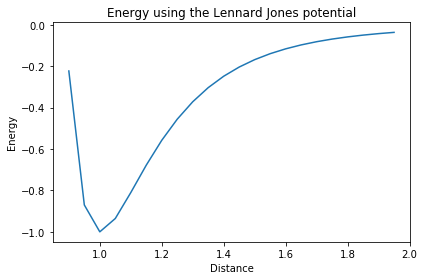

In [24]:
fig, ax = plt.subplots()
ax.plot(distances, energies)
ax.set_title('Energy using the Lennard Jones potential')
ax.set_xlabel('Distance')
ax.set_ylabel('Energy')

plt.tight_layout()
plt.show()

## 3. Molecular Dynamics
Let's set up some Molecular dynamics with a few water molecules. We use the AMSInput GUI to define which settings we need.

<img src='../md_water.png' alt='watermd'>

In [25]:
# We use the runscript to guide our settings
s = Settings()

# setting up the molecular dynamics
s.input.ams.Task = 'MolecularDynamics'
s.input.ams.MolecularDynamics.Nsteps = 10000
s.input.ams.MolecularDynamics.TimeStep = 0.1
s.input.ams.MolecularDynamics.InitialVelocities.Temperature = 10

# Setting up the thermostat
s.input.ams.MolecularDynamics.Thermostat.Type = 'NHC'
s.input.ams.MolecularDynamics.Thermostat.Temperature = 10
s.input.ams.MolecularDynamics.Thermostat.Tau = 15

# Setting up the engine and forcefield
s.input.reaxff.ForceField = ffield
s.input.reaxff.TaperBO = True

In [26]:
# Read in the xyz file with 5 watermolecules quite close to each other
multiple_molecules = '../data/5_water_mol.xyz'
molecules = Molecule(multiple_molecules)

In [27]:
job = AMSJob(molecule=molecules, settings=s)
job.name = 'watermd'

In [28]:
init()
job.run()
finish()

[13:25:21] PLAMS working folder: /work/dumortil/Documents/software/params_runscript_examples/examples/plams_workdir.005
[13:25:21] JOB watermd STARTED
[13:25:21] JOB watermd RUNNING
[13:25:37] JOB watermd FINISHED
[13:25:37] JOB watermd SUCCESSFUL
[13:25:37] PLAMS run finished. Goodbye


## 4. Parameter optimization using ParAMS
Up until now, ParAMS has only been used for some additional support on conversion between the old and new interface. It is only from this point on that ParAMS is to play a major role: the reparametrization of the force field. Note that ParAMS is the standard tool to reparametrize any tool that needs reparametrization in the AMS-suite.

### 4.1 Selecting Parameters to Optimize
We start the process with reading in the force field. Note that this is a major difference than what we did earlier: In the earlier implementation, plams only pointed out to the engine where to find the force field, it never read it out itself. In other words, it is only the ReaxFF C++/fortran code that read in the force field. Using ParAMS, we have tools to read in and edit the Force Field using python itself.

In [29]:
# Note that we read in the force field specifically here.
parameters = ReaxParams(ffield)

In [30]:
# Count how many parameters we have and how many are activated by default
print('Parameters in Force Field: {}'.format(len(parameters)))
print('Parameters that are Activated for Refitting: {}'.format(len(parameters.active)))

Parameters in Force Field: 277
Parameters that are Activated for Refitting: 233


In [31]:
print(parameters[1])

.................................................
Name:     p_boc2;;4d;;Overcoordination parameter
Value:    9.5469
Range:    (7.637520000000001, 11.45628)
Active:   True



Let us now assume in this particular case the LennardJones potential is a DFT-like method that is able to generate very precise training data for ReaxFF. We have noticed that ReaxFF is badly reproducing the O-H bond, and therefore we are going to activate O-H relevant parameters

In [32]:
# First we deactive all the parameters in the force field
for param in parameters:
    param.is_active = False
print('Parameters that are Activated for Refitting: {}'.format(len(parameters.active)))

Parameters that are Activated for Refitting: 0


In [33]:
# We define in which atoms we are interested
atoms_of_interest = ['H','O']

In [34]:
'''
# We have manually selected 4 parameters that we would like to optimise.
# Note that you can also partly automate this process by focussing on the names
to_activate = ['H.O:D_e^sigma;;6,11a;;Sigma-bond dissociation energy',
               'H.O:D_e^pi;;6;;Pi-bond dissociation energy',
               'H.O:p_ovun1;;11a;;Overcoordination penalty',
               'H.O:p_bo2;;2;;Sigma bond order']

for param in parameters:
    if param.name in to_activate:
        param.is_active = True
        '''

"\n# We have manually selected 4 parameters that we would like to optimise.\n# Note that you can also partly automate this process by focussing on the names\nto_activate = ['H.O:D_e^sigma;;6,11a;;Sigma-bond dissociation energy',\n               'H.O:D_e^pi;;6;;Pi-bond dissociation energy',\n               'H.O:p_ovun1;;11a;;Overcoordination penalty',\n               'H.O:p_bo2;;2;;Sigma bond order']\n\nfor param in parameters:\n    if param.name in to_activate:\n        param.is_active = True\n        "

In [35]:
atoms_of_interest = set(['H','O'])
for param in parameters:
    if (set(param.atoms) == atoms_of_interest) and (param.value != 0.0):
        param.is_active = True
        
print('Parameters that are Activated for Refitting: {}'.format(len(parameters.active)))


Parameters that are Activated for Refitting: 45


In [36]:
# ignore: adding a little disturbance to 
# We have manually selected 4 parameters that we would like to optimise.
# Note that you can also partly automate this process by focussing on the names
for param in parameters.active:
        param.value=param.value*(1+np.random.rand()*0.15)

### **ADDENDA** Generating training data using the correct ReaxFF
this is based on the example that we did in section 2. However, ParAMS needs a JobCollection, a more advanced 'list' that combines the settings and molecules. Next, it needs a DataSet where the reference results can be stored. Note that this can also be build up using AMStrain, and then directly red in as a DataSet. This latter approach makes this section unneccesary.

In [37]:
# First we build a set with the molecules. Here we do this separately so
# we can compare both force fields
distances = np.arange(1, 2, 0.05)
molecules = []
for d in distances:
    mol = Molecule()
    atom1 = Atom(symbol='H', coords=(0,0,0))
    atom2 = Atom(symbol='O', coords=(d,0,0))
    mol.add_atom(atom1)
    mol.add_atom(atom2)
    molecules.append(mol)

In [38]:
# Defining the settings for Single Point Lennard Jones
s = Settings()
s.input.ams.Task = 'Singlepoint'
s.input.ReaxFF.ForceField = ffield

In [39]:
JC = JobCollection()

# Now we add the jobs to the jobcollection, combined with the relevant molecule
i=0
for mol, d in zip(molecules, distances):
    jce = JCEntry()
    jce.settings = s
    jce.molecule = mol
    JC.add_entry('OH_{}'.format(i), jce)
    i+=1

In [40]:
# We have calculated the results using the reference engine
refresults = JC.run(s) # Run every entry in JC with engine settings defined in line 25

In [41]:
# Storing the reference results to the trainingset. Here we will train on the energy
DS = DataSet()
for name,entry in JC.items():
    DS.add_entry(f"energy('{name}')", 1.0)

In [42]:
# We extract the results and store them into trainingset.yaml for later use
DS.calculate_reference(refresults)
DS.store('trainingset.yaml')

### 4.2 *bis* Read in a trainset

In [43]:
s = Settings()
s.input.ams.Task = 'geometryoptimization'
s.input.ams.geometryoptimization.Method = 'FIRE'
s.input.ams.geometryoptimization.MaxIterations =100 

In [44]:
# Read in using the function trainset_to_params
trainsetfile = '../data/trainset_water.in'
reference = trainset_to_params(trainsetfile)

In [45]:
print(reference)

---
Expression: distance("water",1,2)
Weight: 1
Unit: angstrom, 0.52918
ReferenceValue: 0.9728029077875956
Sigma: 0.1
---
Expression: distance("water",0,2)
Weight: 1
Unit: angstrom, 0.52918
ReferenceValue: 0.9729085718092934
Sigma: 0.1
---
Expression: angles("water",(0,2,1))
Weight: 1
ReferenceValue: 104.4
Sigma: 5.0
...



In [46]:
JC = JobCollection()
jce = JCEntry()
jce.settings = s
jce.molecule = Molecule(xyz)
JC.add_entry('water',jce)

### 4.3 Setting up the configurations for the optimization
In this part, we will define the optimizer, callbacks and so on. The optimizer will be set as a CMAOptimizer, while we will use a callback of 2 minutes and a Logger.

In [47]:
# Setting the optimizer
optimizer = CMAOptimizer(sigma=0.03, popsize=10)

# Setting the callback
callbacks = [Timeout(2*60), Logger(), TargetValue(10)]

### 4.4 Start the optimization
This is done using two line command where we provide the optimizer, callbacks and training set

In [48]:
optim = Optimization(JC, reference, parameters, optimizer, callbacks=callbacks)
optim.optimize()

Directory 'opt' already exists. Will use 'opt.008' instead.
2021-06-21 13:25:41 Starting parameter optimization.
Initial f(x)=1.355e+02
Now at evaluation 0
Best f(x)=1.194e+02
Best f(x)=1.187e+02
Best f(x)=1.171e+02
Best f(x)=1.108e+02
Best f(x)=1.067e+02
Best f(x)=1.042e+02
Best f(x)=1.005e+02
Best f(x)=9.606e+01
Best f(x)=9.563e+01
Best f(x)=8.852e+01
Best f(x)=8.730e+01
Best f(x)=8.667e+01
Best f(x)=8.541e+01
Best f(x)=8.505e+01
Best f(x)=8.468e+01
Now at evaluation 100
Best f(x)=8.429e+01
Now at evaluation 200
Now at evaluation 300
Best f(x)=8.420e+01
Now at evaluation 400
Best f(x)=8.420e+01
Best f(x)=8.418e+01
Now at evaluation 500
Now at evaluation 600
Now at evaluation 700
Callback: Timeout
Optimization done after 0:02:01
Final fitness function value is f(x)=8.418e+01
